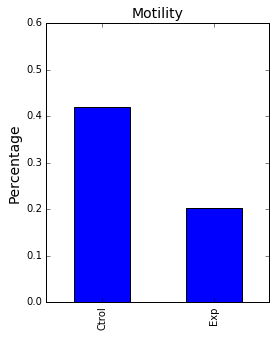

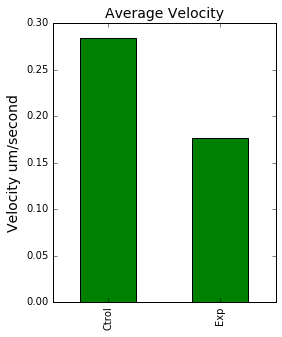

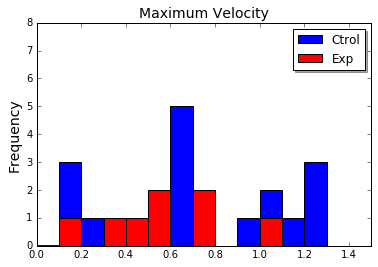

In [2]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
%matplotlib inline
#create excel file
writer1 = pd.ExcelWriter('Maximum_Velocity.xlsx', engine='xlsxwriter')
writer2 = pd.ExcelWriter('Average_Velocity.xlsx', engine='xlsxwriter')
writer3 = pd.ExcelWriter('Motility.xlsx', engine='xlsxwriter')
#universal variable
motility_dict = {}
average_velocity_dict = {}
maximum_velocity_dict = {}
maximum_velocity = []
maximum_velocity_Ctrol = []
maximum_velocity_Exp = []
#open multiple files
for FileList in glob.glob("Data/*.xls"):
    motility=[]
    average_velocity_list=[]
    xls = pd.ExcelFile(FileList)
    #read image width
    xls.parse('Sheet2', index_col=None, na_values=['NA'])
    data2 = pd.read_excel(FileList, 'Sheet2', index_col=None, na_values=['NA'])
    s = data2['size']
    len_sample=s[0]-20
    #read file data
    xls.parse('Sheet1', index_col=None, na_values=['NA'])
    data = pd.read_excel(FileList, 'Sheet1', index_col=None, na_values=['NA'])
    #determine group
    if 'Ctrol' in FileList:
        group_id = 'Ctrol'
    else:
        group_id = 'Exp'
    motility.append(group_id)
    average_velocity_list.append(group_id)
    #GroupIndexing
    data['GroupIdx']=0
    #data.index = data.Index
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    counting = 0
    for idx, row in data.iterrows():
        if row['Y'] <= 20:
            counting = counting + 1
            row['GroupIdx'] = counting
        elif row['X'] <= 20 and row['Y'] < 1980 and (data.X.iloc[idx-2] <= 20 or data.Y.iloc[idx-2] >= 1980 or data.X.iloc[idx-2] >= len_sample):
            counting = counting + 1
            row['GroupIdx'] = counting
        #length of the image#
        elif row['X'] >= len_sample and row['Y'] < 1980 and (data.X.iloc[idx-2] <= 20 or data.Y.iloc[idx-2] >= 1980 or data.X.iloc[idx-2] >= len_sample):
            counting = counting + 1
            row['GroupIdx'] = counting
        else:
            row['GroupIdx'] = counting 
    grouped = data.groupby('GroupIdx')
    #DataFrame to dict
    index_len = len(data)
    i = 0
    dict={}
    while i < index_len:
        if i == 0:
            dict[data.GroupIdx.iloc[i]]=[]
        elif data.GroupIdx.iloc[i] == data.GroupIdx.iloc[i-1]+1:
            dict[data.GroupIdx.iloc[i]]=[]
        element = {}
        element['X']=data.X.iloc[i]
        element['Y']=data.Y.iloc[i]
        dict[data.GroupIdx.iloc[i]].append(element)
        i = i + 1
    #motile
    pixel_per_um = 4.551 
    motile_mito = 0
    stationary_mito = 0
    for key, value in dict.items():
        total_distance = abs(value[0]['X'] - value[len(value)-1]['X']) / pixel_per_um
        if total_distance <= 10:
            stationary_mito = stationary_mito + 1
        else:
            motile_mito = motile_mito + 1
    percentage_stationary = stationary_mito/(stationary_mito + motile_mito)
    percentage_motile = motile_mito/(stationary_mito + motile_mito)
    motility.append(percentage_motile)
    #velocity(average and leg-specific)
    average_velocity = {}
    for key, value in dict.items():
        X = 0
        Y = 0
        total_distance = 0
        total_time = 0
        maximum_v = 0
        velocity = 0
        for element in dict[key]:
            if X == 0 and Y == 0:
                element['velocity'] = 0
                distance = 0
            else:
                distance = abs(element['X']-X)/4.551
                time = abs(element['Y']-Y) * 900/2000
                velocity = distance/time
                element['distance'] = distance
                element['time'] = time
                element['velocity'] = velocity
            if velocity > maximum_v:
                maximum_v = velocity
            if distance > 0:
                total_distance = total_distance + distance
                total_time = total_time + time
            X = element['X']
            Y = element['Y']
        if total_distance > 10 and total_time != 0:
            average_v = total_distance/total_time
        else:
            average_v = 0
            maximum_v = 0
        if maximum_v != 0:
            if group_id == 'Ctrol':
                maximum_velocity_Ctrol.append(maximum_v)
            else:
                maximum_velocity_Exp.append(maximum_v)
        average_velocity[key]=average_v
    #calculate average velocity for one sample
    speed_sum = 0
    mito_number = 0
    AverageSpeed = 0
    for key, value in average_velocity.items():
        if value != 0:
            speed_sum = speed_sum + value
            mito_number = mito_number + 1
    AverageSpeed = speed_sum/mito_number
    average_velocity_list.append(AverageSpeed)
    motility_dict[FileList]= motility
    average_velocity_dict[FileList]= average_velocity_list
#save maximum velocity of each events#
maximum_velocity_dict['Ctrol'] = maximum_velocity_Ctrol
maximum_velocity_dict['Exp'] = maximum_velocity_Exp
Maximum_Velocity_index = {'category': range(1,len(maximum_velocity)+1)}
Maximum_Velocity_df = pd.DataFrame(Maximum_Velocity_index, columns = ['category'])
Maximum_Velocity_df = pd.DataFrame.from_dict(maximum_velocity_dict, orient='index')
Maximum_Velocity_df = pd.DataFrame.transpose(Maximum_Velocity_df)
Maximum_Velocity_df.to_excel(writer1, sheet_name='Sheet1')
#save average velocity
Average_Velocity_index = {'category': range(1,len(average_velocity_dict)+1)}
Average_Velocity_df = pd.DataFrame(Average_Velocity_index, columns = ['category'])
Average_Velocity_df = pd.DataFrame.from_dict(average_velocity_dict, orient='columns', dtype=float)
Average_Velocity_df = pd.DataFrame.transpose(Average_Velocity_df)
Average_Velocity_df.columns = ['category', 'average velocity']
Average_Velocity_df.to_excel(writer2, sheet_name='Sheet1')
#save motility and average velocity results into one dataframe
Motility_index = {'category': range(1,len(motility_dict)+1)}
Motility_df = pd.DataFrame(Motility_index, columns = ['category'])
Motility_df = pd.DataFrame.from_dict(motility_dict, orient='columns', dtype=float)
Motility_df = pd.DataFrame.transpose(Motility_df)
Motility_df.columns = ['category', 'motility']
Motility_df.to_excel(writer3, sheet_name='Sheet1')
#save result excel files#
writer1.save()
writer2.save()
writer3.save()
#Motility chart
Motility_df[['motility']] = Motility_df[['motility']].apply(pd.to_numeric)
Motility_df.index = Motility_df.category
del Motility_df.index.name
grouped = Motility_df.groupby(level=0)
grouped.mean()
p_motility = grouped.mean().plot.bar(legend=False, figsize=(4,5))
p_motility.set_title("Motility", fontsize=14);
p_motility.set_ylabel("Percentage", fontsize=14);
p_motility.set_ylim(0, 0.6)
#Average velocity chart
Average_Velocity_df[['average velocity']] = Average_Velocity_df[['average velocity']].apply(pd.to_numeric)
Average_Velocity_df.index = Average_Velocity_df.category
del Average_Velocity_df.index.name
grouped = Average_Velocity_df.groupby(level=0)
grouped.mean()
p_average_velocity = grouped.mean().plot.bar(legend=False, figsize=(4,5), color='g')
p_average_velocity.set_title("Average Velocity", fontsize=14);
p_average_velocity.set_ylabel("Velocity um/second", fontsize=14);
p_average_velocity.set_ylim(0, 0.3)
#Maximum velocity chart
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(maximum_velocity_Ctrol, bins=np.arange(0, 2, 0.1), color= 'b', label= 'Ctrol')
ax.hist(maximum_velocity_Exp, bins=np.arange(0, 2, 0.1), color= 'r', label= 'Exp')
ax.set_xlim(0, 1.5)
ax.set_ylim(0, 8)
ax.set_title("Maximum Velocity", fontsize=14);
ax.set_ylabel("Frequency", fontsize=14);
legend = ax.legend(loc='upper right', shadow=True)

In [ ]:
`